In this code the classification report is printed for every models

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

SEED = 15243
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)

plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif")

2024-05-05 05:48:41.635679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 05:48:41.635788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 05:48:41.791520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
BATCH_SIZE = 25
DATA_DIR = ("/kaggle/input/lung-and-colon-cancer-histopathological-images/"
            "lung_colon_image_set/lung_image_sets")
IMG_SIZE = 256
MAX_EPOCHS = 25
class_names = ["lung_n", "lung_aca", "lung_scc"]
class_details = ["No Cancer", "Adenocarcinoma", "Squamous Cell Carcinoma"]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="training",
    validation_split=0.2
)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="validation", 
    validation_split=0.2
)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


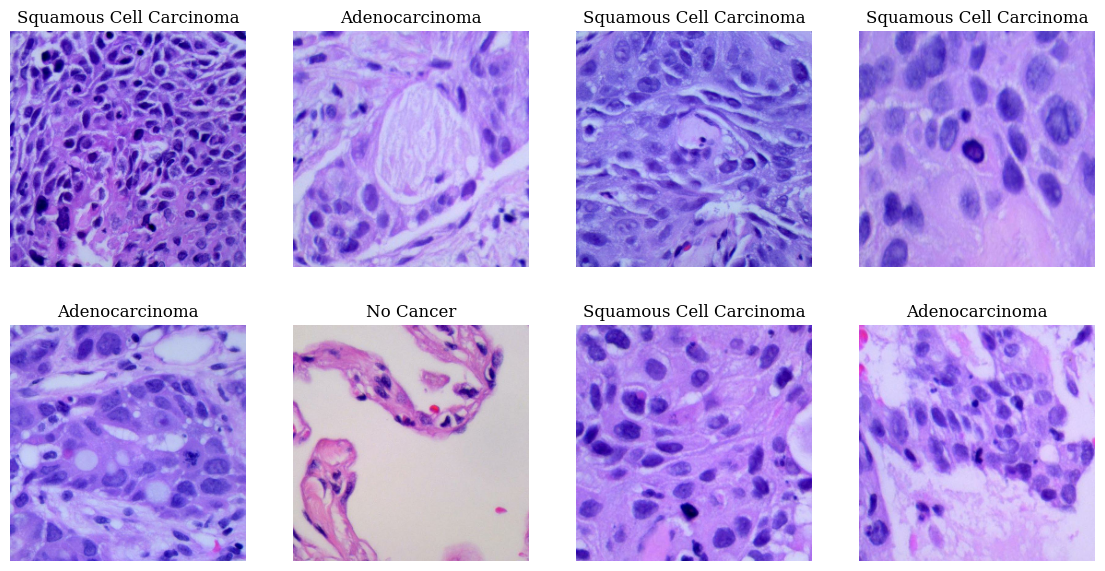

In [3]:
plt.figure(figsize=(14, 7))
for images, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_details[labels[i]])
        plt.axis("off")

In [4]:
# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache(".cached-data").prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)


def compile_and_fit_model(model: tf.keras.Sequential) -> tf.keras.callbacks.History:
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=5,
        mode="auto",
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=0.001
    )
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=MAX_EPOCHS,
        callbacks=[early_stopping, reduce_lr]
    )
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax, metric in zip(axes.flat, ["accuracy", "loss"]):
        performance_df.filter(like=metric).plot(ax=ax)
        ax.set_title(metric.title(), size=15, pad=20)
    return history


def plot_predictions(model: tf.keras.Sequential) -> None:
    plt.figure(figsize=(14, 14))
    for images, labels in train_ds.take(1):
        labels = labels.numpy()
        predicted_labels = np.argmax(model.predict(images), axis=1)
        for i, (actual, pred) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if actual == pred:
                plt.title(class_details[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_details[predicted_labels[i]]}\n"
                          + f"(Actual: {class_details[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

# Model with VGG16 base

In [5]:
pretrained_vgg16_base = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_vgg16_base.trainable = False

vgg16_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.vgg16.preprocess_input),
    pretrained_vgg16_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
vgg16_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 14780739 (56.38 MB)
Trainable params: 66051 (258.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Epoch 1/25


I0000 00:00:1714888162.308562     131 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


480/480 [==============================] - 94s 173ms/step - loss: 0.1521 - accuracy: 0.9467 - val_loss: 0.0777 - val_accuracy: 0.9687 - lr: 0.0010
Epoch 2/25
480/480 [==============================] - 87s 180ms/step - loss: 0.0552 - accuracy: 0.9795 - val_loss: 0.0573 - val_accuracy: 0.9797 - lr: 0.0010
Epoch 3/25
480/480 [==============================] - 86s 179ms/step - loss: 0.0341 - accuracy: 0.9887 - val_loss: 0.0654 - val_accuracy: 0.9740 - lr: 0.0010
Epoch 4/25
480/480 [==============================] - 86s 179ms/step - loss: 0.0235 - accuracy: 0.9920 - val_loss: 0.0681 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 5/25
480/480 [==============================] - 86s 178ms/step - loss: 0.0189 - accuracy: 0.9930 - val_loss: 0.0639 - val_accuracy: 0.9760 - lr: 0.0010
Epoch 6/25
480/480 [==============================] - 86s 179ms/step - loss: 0.0306 - accuracy: 0.9892 - val_loss: 0.0502 - val_accuracy: 0.9803 - lr: 0.0010
Epoch 7/25
480/480 [==============================] - 86s 179ms

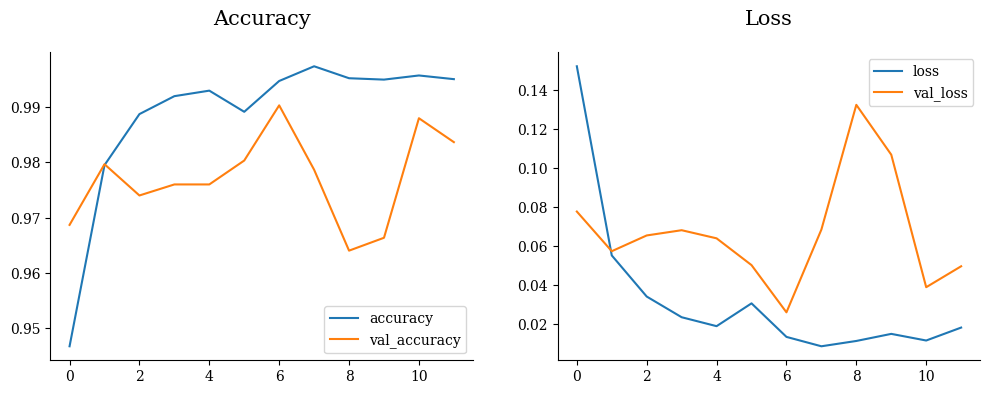

In [6]:
vgg16_history = compile_and_fit_model(vgg16_model)

1/1 [==============================] - 0s 231ms/step


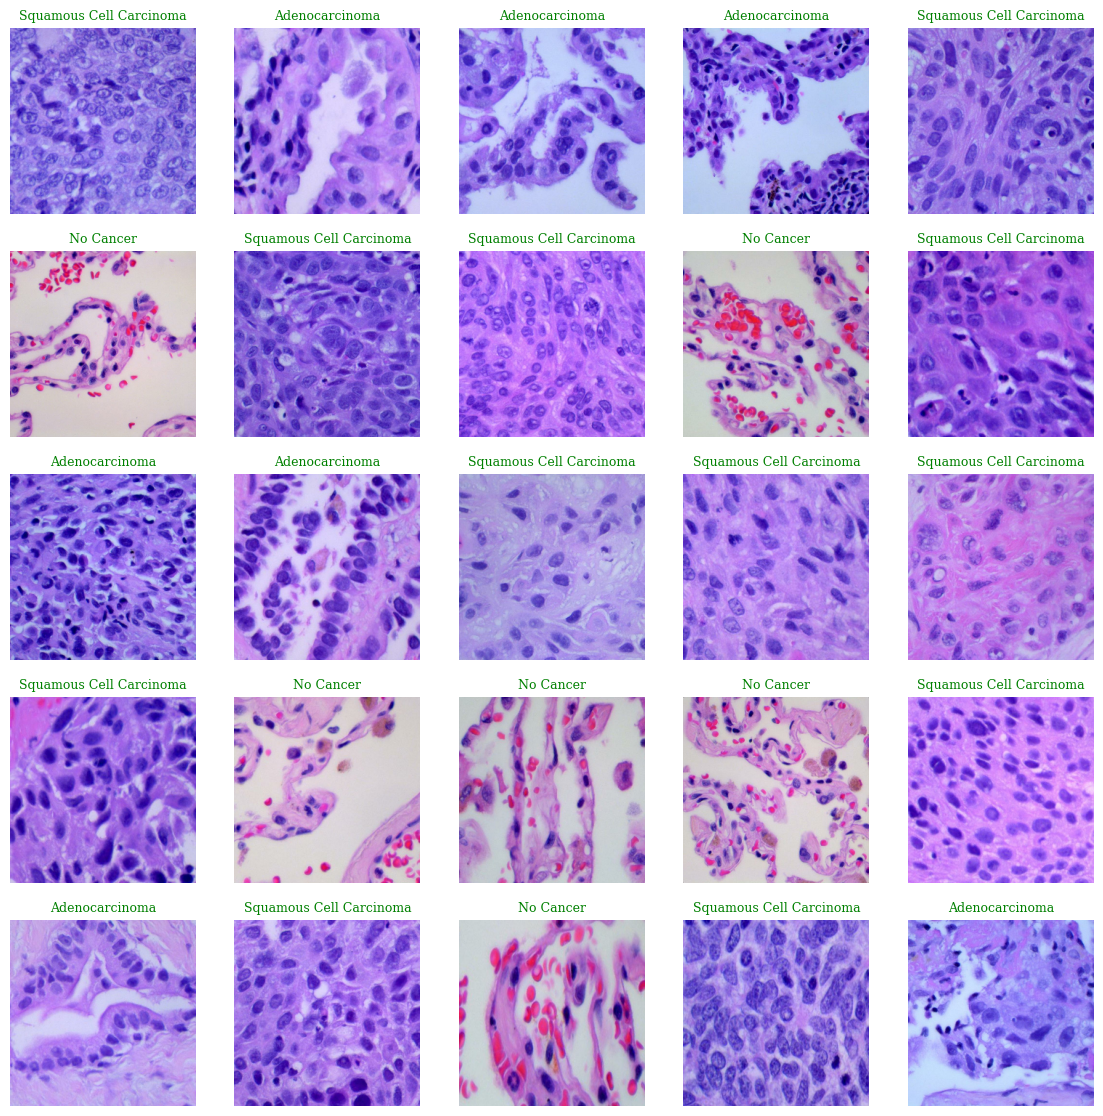

In [7]:
plot_predictions(vgg16_model)

# Model with ResNet50 base

In [8]:
pretrained_resnet_base = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_resnet_base.trainable = False

resnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input),
    pretrained_resnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
resnet_model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 256, 256, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 23827459 (90.89 MB)
Trainable params: 262659 (1.00 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


Epoch 1/25
480/480 [==============================] - 58s 109ms/step - loss: 0.1247 - accuracy: 0.9488 - val_loss: 0.0941 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 2/25
480/480 [==============================] - 50s 105ms/step - loss: 0.0665 - accuracy: 0.9739 - val_loss: 0.0786 - val_accuracy: 0.9687 - lr: 0.0010
Epoch 3/25
480/480 [==============================] - 51s 106ms/step - loss: 0.0419 - accuracy: 0.9857 - val_loss: 0.0714 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 4/25
480/480 [==============================] - 50s 105ms/step - loss: 0.0277 - accuracy: 0.9909 - val_loss: 0.0593 - val_accuracy: 0.9817 - lr: 0.0010
Epoch 5/25
480/480 [==============================] - 51s 106ms/step - loss: 0.0234 - accuracy: 0.9916 - val_loss: 0.0547 - val_accuracy: 0.9813 - lr: 0.0010
Epoch 6/25
480/480 [==============================] - 51s 105ms/step - loss: 0.0186 - accuracy: 0.9930 - val_loss: 0.0521 - val_accuracy: 0.9830 - lr: 0.0010
Epoch 7/25
480/480 [==============================] 

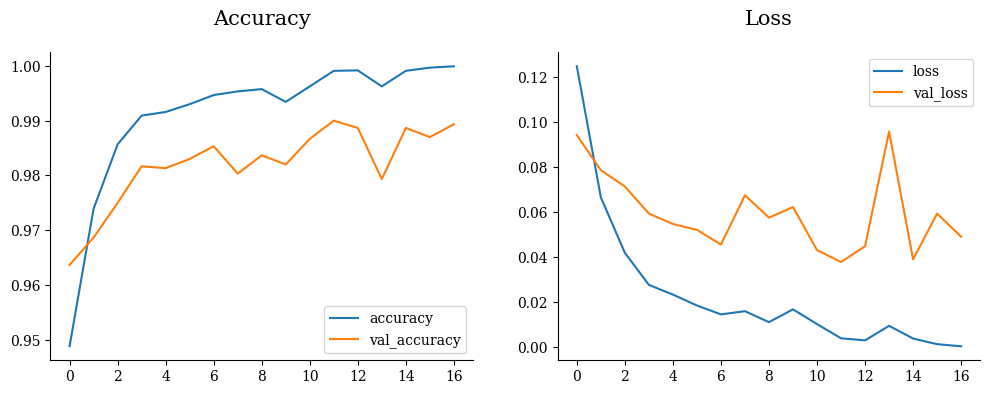

In [9]:
resnet_history = compile_and_fit_model(resnet_model)

1/1 [==============================] - 1s 862ms/step


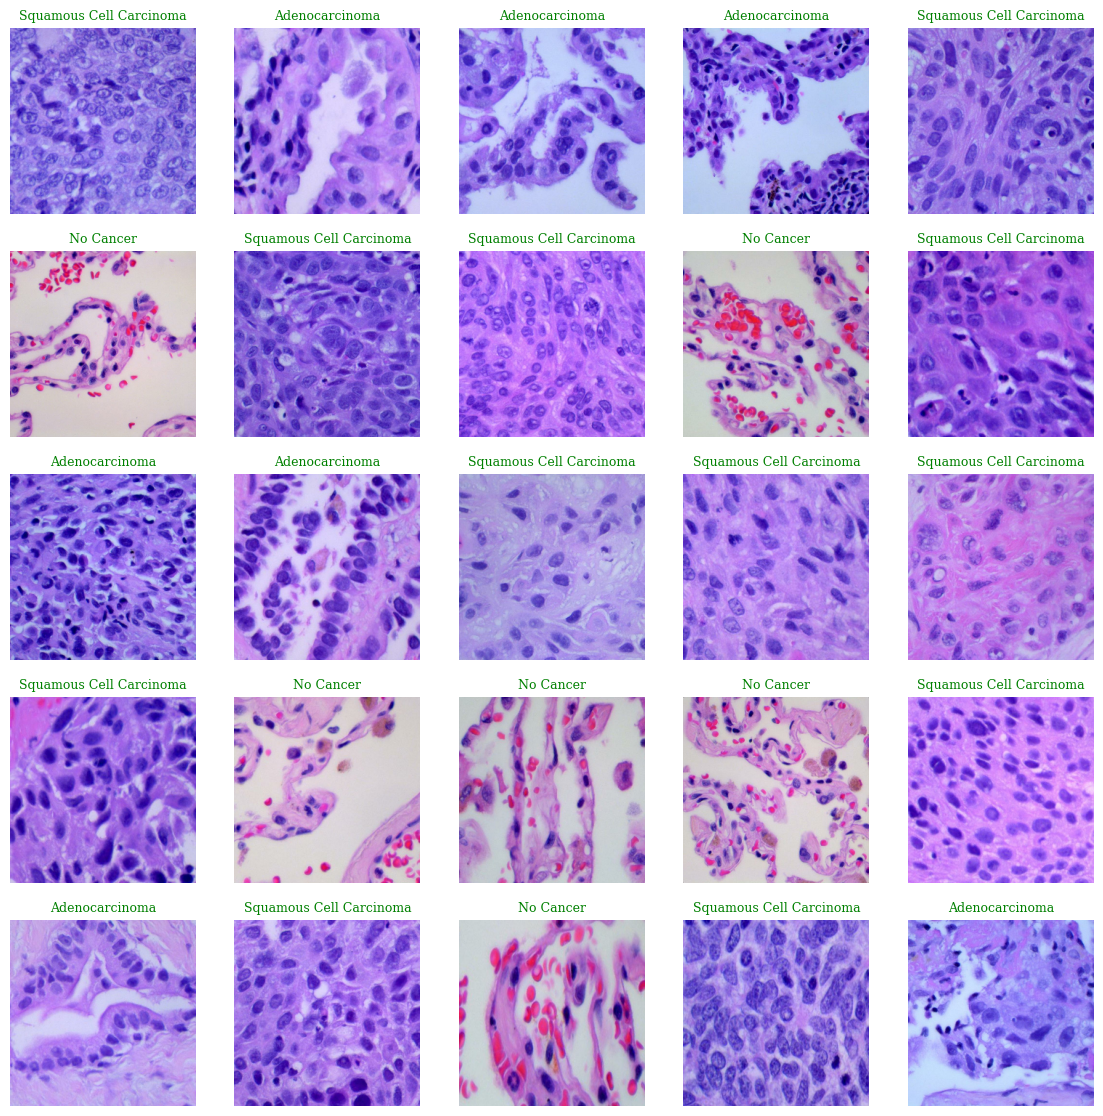

In [10]:
plot_predictions(resnet_model)

# Model with EfficientNetB1 base

In [11]:
pretrained_efficientnet_base = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_efficientnet_base.trainable = False

efficientnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    pretrained_efficientnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
efficientnet_model.summary()

27018416/27018416 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 1280)              6575239   
 )                                                               
                                                                 
 dense_4 (Dense)             (None, 128)               163968    
                                                                 
 dense_5 (Dense)             (None, 3)                 387       
                                                                 
Total params: 6739594 (25.71 MB)
Trainable params: 164355 (642.01 KB)
Non-trainable params: 6575239 (25.08 MB)
_________________________________________________________________


Epoch 1/25


2024-05-05 06:21:22.549467: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


480/480 [==============================] - 65s 112ms/step - loss: 0.1107 - accuracy: 0.9555 - val_loss: 0.0447 - val_accuracy: 0.9837 - lr: 0.0010
Epoch 2/25
480/480 [==============================] - 49s 102ms/step - loss: 0.0500 - accuracy: 0.9803 - val_loss: 0.0315 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 3/25
480/480 [==============================] - 49s 102ms/step - loss: 0.0362 - accuracy: 0.9858 - val_loss: 0.0223 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 4/25
480/480 [==============================] - 49s 102ms/step - loss: 0.0279 - accuracy: 0.9898 - val_loss: 0.0206 - val_accuracy: 0.9920 - lr: 0.0010
Epoch 5/25
480/480 [==============================] - 49s 102ms/step - loss: 0.0239 - accuracy: 0.9908 - val_loss: 0.0124 - val_accuracy: 0.9963 - lr: 0.0010
Epoch 6/25
480/480 [==============================] - 49s 102ms/step - loss: 0.0195 - accuracy: 0.9929 - val_loss: 0.0619 - val_accuracy: 0.9720 - lr: 0.0010
Epoch 7/25
480/480 [==============================] - 49s 102ms

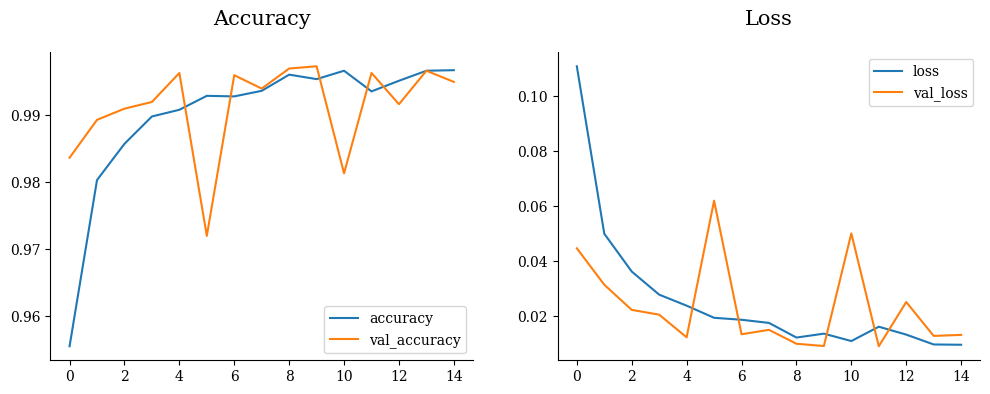

In [12]:
efficientnet_history = compile_and_fit_model(efficientnet_model)

1/1 [==============================] - 2s 2s/step


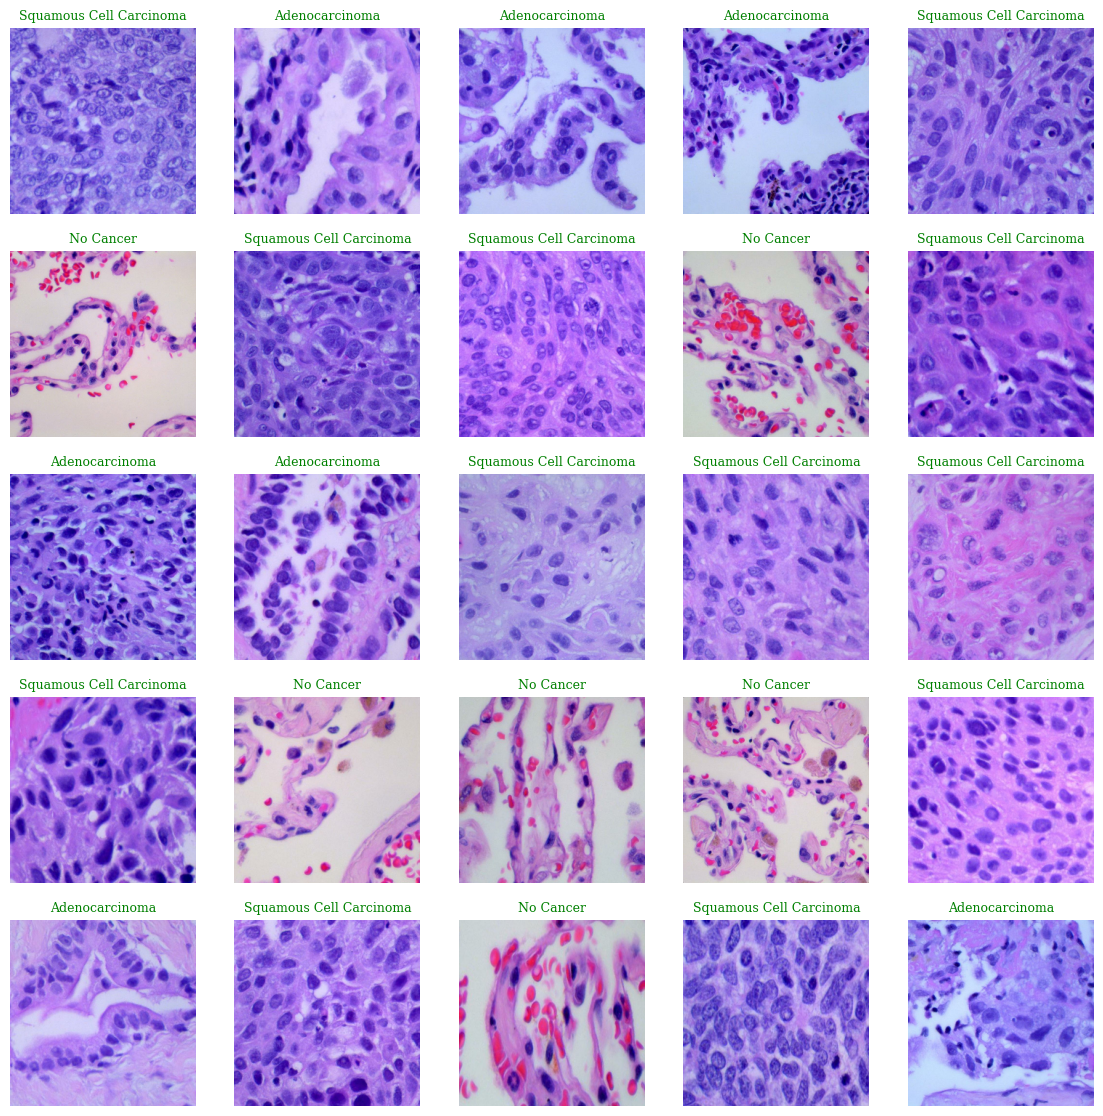

In [13]:
plot_predictions(efficientnet_model)

In [48]:
model_save_path = "efficientnetb1_model.keras"
efficientnet_model.save(model_save_path)

print(f"Model saved successfully to {model_save_path}")

Model saved successfully to efficientnetb1_model.keras


# Comparison between 3 models

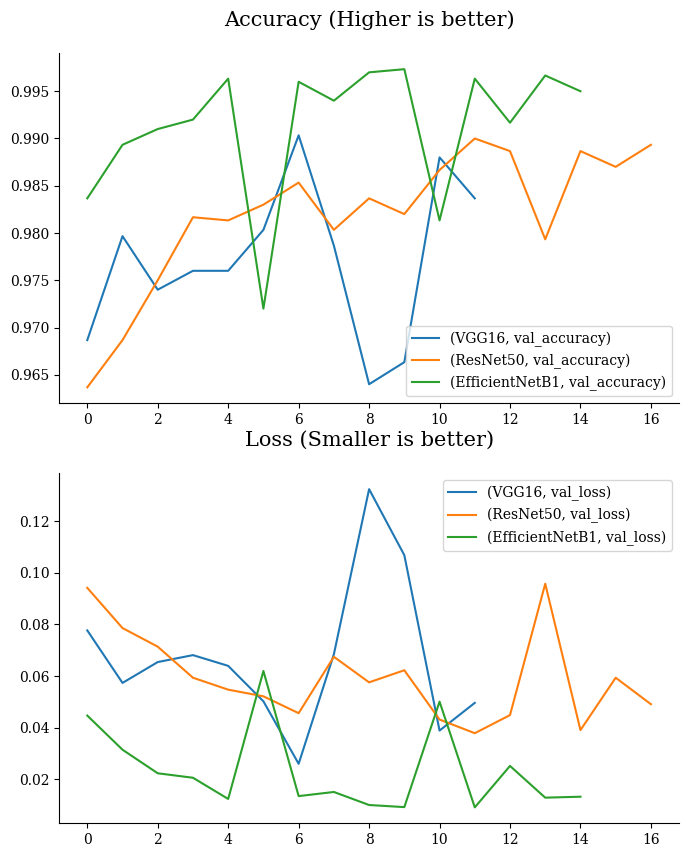

In [14]:
vgg_df = pd.DataFrame(vgg16_history.history)
resnet_df = pd.DataFrame(resnet_history.history)
efficientnet_df = pd.DataFrame(efficientnet_history.history)
combined = pd.concat([vgg_df, resnet_df, efficientnet_df], axis=1,
                     keys=["VGG16", "ResNet50", "EfficientNetB1"])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))
combined.filter(like="val_accuracy").plot(ax=ax1)
combined.filter(like="val_loss").plot(ax=ax2)
ax1.set_title("Accuracy (Higher is better)", size=15, pad=20)
ax1.legend(title="")
ax2.set_title("Loss (Smaller is better)", size=15, pad=20)
_ = ax2.legend(title="")

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion Matrices and classification report of three models

120/120 [==============================] - 17s 141ms/step


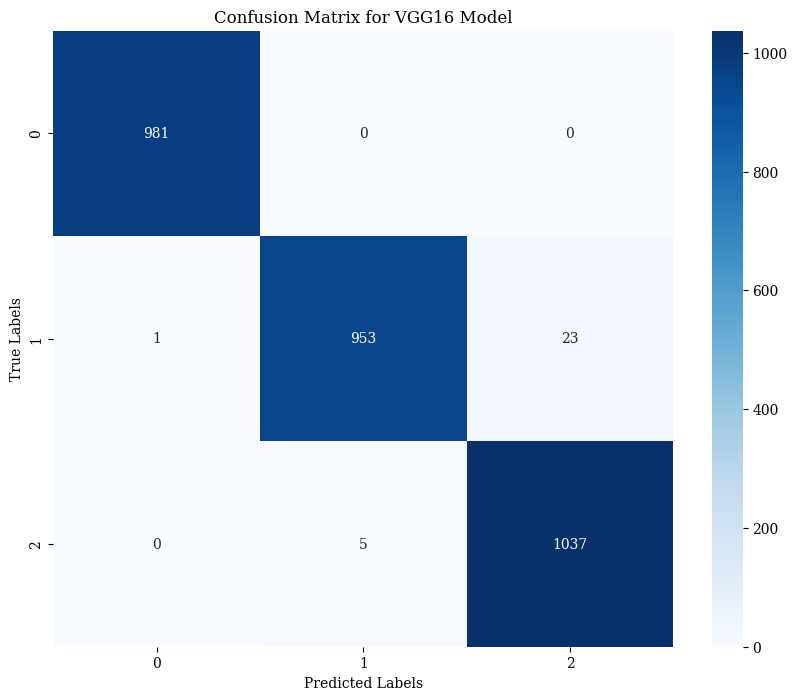

Classification Report for VGG16 Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       981
           1       0.99      0.98      0.99       977
           2       0.98      1.00      0.99      1042

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [20]:
from sklearn.metrics import classification_report

# Get the predicted labels for the validation dataset
vgg16_predicted_labels = np.argmax(vgg16_model.predict(validation_ds), axis=1)

# Get the true labels for the validation dataset
vgg16_true_labels = []
for _, labels in validation_ds:
    vgg16_true_labels.extend(labels.numpy())

# Generate the confusion matrix
vgg16_confusion_matrix = confusion_matrix(vgg16_true_labels, vgg16_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(vgg16_confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for VGG16 Model')
plt.show()

# Generate the classification report
vgg16_classification_report = classification_report(vgg16_true_labels, vgg16_predicted_labels)

# Print the classification report
print("Classification Report for VGG16 Model:")
print(vgg16_classification_report)


120/120 [==============================] - 10s 82ms/step


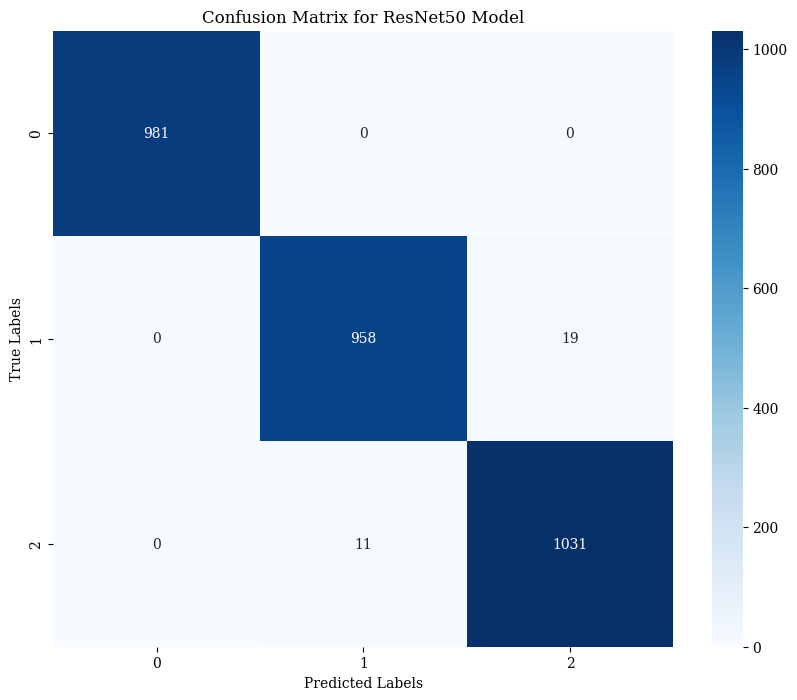

Classification Report for ResNet50 Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       981
           1       0.99      0.98      0.98       977
           2       0.98      0.99      0.99      1042

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [22]:
from sklearn.metrics import classification_report

# Get the predicted labels for the validation dataset
resnet_predicted_labels = np.argmax(resnet_model.predict(validation_ds), axis=1)

# Get the true labels for the validation dataset
resnet_true_labels = []
for _, labels in validation_ds:
    resnet_true_labels.extend(labels.numpy())

# Generate the confusion matrix
resnet_confusion_matrix = confusion_matrix(resnet_true_labels, resnet_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(resnet_confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for ResNet50 Model')
plt.show()

# Generate and print the classification report
resnet_classification_report = classification_report(resnet_true_labels, resnet_predicted_labels)
print("Classification Report for ResNet50 Model:")
print(resnet_classification_report)

120/120 [==============================] - 9s 75ms/step


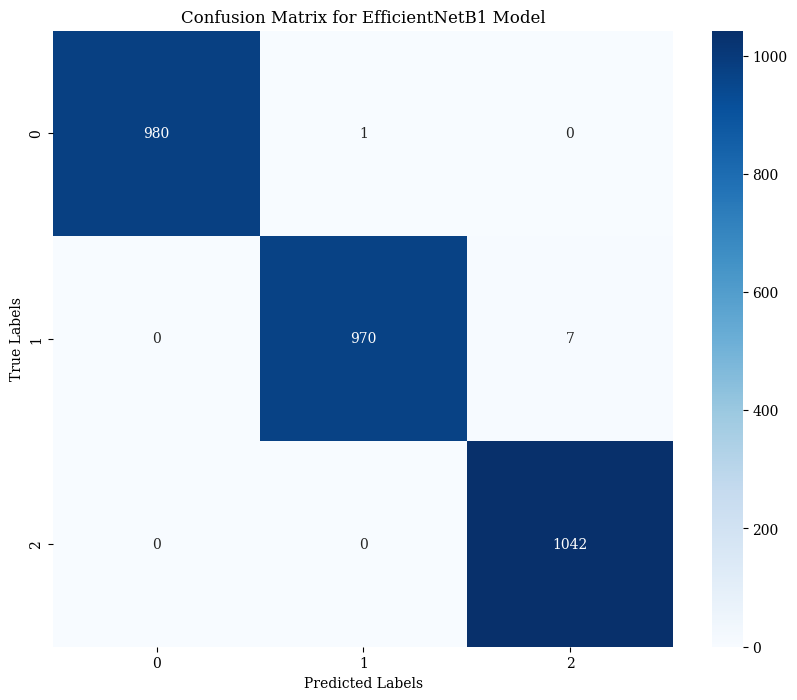

Classification Report for EfficientNetB1 Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       981
           1       1.00      0.99      1.00       977
           2       0.99      1.00      1.00      1042

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [23]:
from sklearn.metrics import classification_report

# Get the predicted labels for the validation dataset
efficientnet_predicted_labels = np.argmax(efficientnet_model.predict(validation_ds), axis=1)

# Get the true labels for the validation dataset
efficientnet_true_labels = []
for _, labels in validation_ds:
    efficientnet_true_labels.extend(labels.numpy())

# Generate the confusion matrix
efficientnet_confusion_matrix = confusion_matrix(efficientnet_true_labels, efficientnet_predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(efficientnet_confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for EfficientNetB1 Model')
plt.show()

# Generate and print the classification report
efficientnet_classification_report = classification_report(efficientnet_true_labels, efficientnet_predicted_labels)
print("Classification Report for EfficientNetB1 Model:")
print(efficientnet_classification_report)